In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [2]:
data = pd.read_csv('solver-comparison.csv')

# Data Cleaning
If the instance could not be solved, set its solving time equal to the maximum value.

In [3]:
max_cpu_time = 5000
data['cpu_time'] = data.apply(lambda row: max_cpu_time if row['satisfiability'] == 'INDETERMINATE' else row['cpu_time'], axis=1)

# Compute normalized statistics

In [4]:
data['adjusted_time'] = data.apply(lambda row: row['cpu_time'    ] - row['er_time'      ], axis=1)
data['overhead_frac'] = data.apply(lambda row: row['er_time'     ] / row['cpu_time'     ], axis=1)
data['conf_per_dec' ] = data.apply(lambda row: row['conflicts'   ] / row['decisions'    ], axis=1)
data['prop_per_dec' ] = data.apply(lambda row: row['propagations'] / row['decisions'    ], axis=1)
data['conf_per_sec' ] = data.apply(lambda row: row['conflicts'   ] / row['adjusted_time'], axis=1)
data['avg_lbd'      ] = data.apply(lambda row: row['total_lbd'   ] / row['conflicts'    ], axis=1)
data['ev_conf_frac' ] = data.apply(lambda row: row['ev_conflicts'] / row['conflicts'    ], axis=1)
data['conf_per_ev'  ] = data.apply(lambda row: row['ev_conflicts'] / row['num_ev'       ] if row['num_ev'] else np.nan, axis=1)

# Explanation of Columns
Here, we list the statistics which are captured from running the solvers. Normalized statistics are computed and described later.

## Solver Configuration
* `solver`: Solver name
* `heuristic`: Heuristic used for introducing extension variables
* `sub_defn`: Substitute extension variables into clauses where their definitions occur
* `ext_freq`: How often to try introducing extension variables (minimum number of conflicts that must have occurred before searching for an extension variable)
* `window_size`: Maximum number of clauses to consider when introducing a new extension variable
* `max_new_ev`: Maximum number of new extension variables to introduce at once
* `force_branch`: Whether to force branching on new extension variables

## Base Solver Performance Statistics
* `problem`: The name of the CNF instance
* `restarts`: The total number of restarts
* `conflicts`: The total number of conflicts
* `decisions`: The total number of decisions
* `propagations`: The total number of propagations
* `conf_lits`: The total number of conflict literals
* `num_ev`: The total number of extension variables introduced
* `ev_decisions`: The total number of decisions on an extension variable
* `ev_conflicts`: The total number of times a clause containing extension variables participates in a conflict
* `ev_learnt`: The total number of times a learnt clause contains an extension variable
* `total_lbd`: The total Literal Block Distance of all learnt clauses
* `mem_used`: The total amount of memory (in MB) used for the instance
* `cpu_time`: The total amount of time (in seconds) used for the instance
* `er_time`: The total amount of time (in seconds) used for doing work related to Extended Resolution (e.g., searching for a new extension variable)
* `satisfiability`: The computed satisfiability of the formula

## Normalized Solver Performance Statistics
* `adjusted_time`: CPU time - overhead associated with Extended Resolution
* `overhead_frac`: The fraction of total time taken for Extended Resolution
* `conf_per_dec`: The number of conflicts per decision (a.k.a. GLR: Global Learning Rate)
* `prop_per_dec`: The number of propagations per decision
* `conf_per_sec`: The number of conflicts per second (using adjusted time)
* `avg_lbd`: The average LBD (literal block distance) per learnt clause
* `ev_conf_frac`: The proportion of all conflicts which involve conflict clauses
* `conf_per_ev`: The average number of conflicts involving an extension clause per extension variable

In [5]:
data

,solver,heuristic,sub_defn,ext_freq,window_size,max_new_ev,force_branch,problem,restarts,conflicts,...,er_time,satisfiability,adjusted_time,overhead_frac,conf_per_dec,prop_per_dec,conf_per_sec,avg_lbd,ev_conf_frac,conf_per_ev
0,maplesat_static_none,none,NaN,NaN,NaN,NaN,NaN,verification/zipcpu-busdelay-p46.aig_unroll20_...,94,25770,...,0.000000,UNSATISFIABLE,1.255690,0.000000,0.632175,58.498528,20522.581210,11.030695,0.000000,NaN
1,maplesat_static_none,none,NaN,NaN,NaN,NaN,NaN,verification/zipcpu-busdelay-p36.aig_unroll22_...,254,87856,...,0.000000,UNSATISFIABLE,7.774400,0.000000,0.662324,56.526642,11300.679152,12.220201,0.000000,NaN
2,maplesat_static_none,none,NaN,NaN,NaN,NaN,NaN,verification/VexRiscv-regch0-20-p1.aig_unroll2...,990,405766,...,0.000000,UNSATISFIABLE,72.984100,0.000000,0.079944,32.557681,5559.649293,12.579373,0.000000,NaN
3,maplesat_static_none,none,NaN,NaN,NaN,NaN,NaN,verification/dspfilters_fastfir_second-p07.aig...,131,45347,...,0.000000,UNSATISFIABLE,60.934900,0.000000,0.250037,884.250820,744.187649,9.457781,0.000000,NaN
4,maplesat_static_none,none,NaN,NaN,NaN,NaN,NaN,verification/dspfilters_fastfir_second-p45.aig...,1914,881145,...,0.000000,UNSATISFIABLE,1040.080000,0.000000,0.202412,615.081803,847.189639,14.543886,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,maplesat_static_sub_rep1_force1_2000_100_10,sub,1.0,2000.0,100.0,10.0,1.0,rand426_150,18,3554,...,0.010184,UNSATISFIABLE,0.068459,0.129497,0.821544,25.057559,51914.284462,5.850028,0.166573,592.0
203,maplesat_static_sub_rep1_force1_2000_100_10,sub,1.0,2000.0,100.0,10.0,1.0,rand426_200,49,11493,...,0.037083,UNSATISFIABLE,0.320253,0.103776,0.837927,30.339312,35887.251642,6.730184,0.014009,80.5
204,maplesat_static_sub_rep1_force1_2000_100_10,sub,1.0,2000.0,100.0,10.0,1.0,rand426_250,338,125607,...,0.959754,UNSATISFIABLE,12.573346,0.070919,0.853332,36.868522,9989.942216,8.446973,0.411490,25843.0
205,maplesat_static_sub_rep1_force1_2000_100_10,sub,1.0,2000.0,100.0,10.0,1.0,rand426_300,888,365676,...,4.529350,UNSATISFIABLE,72.678450,0.058664,0.859801,40.497824,5031.422657,9.496740,0.000484,177.0


# Summarize Solver Performance

Compute percentage overhead for each ER solver variant.

,overhead_frac
,mean
solver,
maplesat_static_none,0.000000
maplesat_static_rnd_rep0_force0_2000_20_1,0.019405
maplesat_static_rnd_rep0_force1_2000_20_1,0.016876
maplesat_static_rnd_rep1_force0_2000_20_1,0.073877
maplesat_static_rnd_rep1_force1_2000_20_1,0.061738
maplesat_static_sub_rep0_force0_2000_100_10,0.117557
maplesat_static_sub_rep0_force1_2000_100_10,0.116587
maplesat_static_sub_rep1_force0_2000_100_10,0.137602


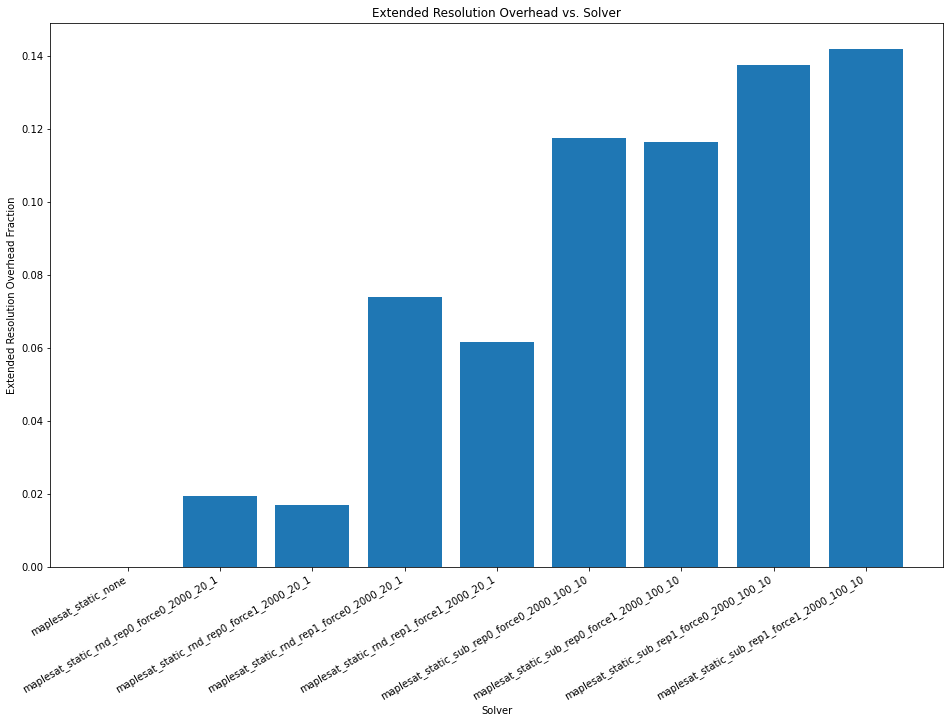

In [6]:
overhead_summary = data.groupby('solver').agg({'overhead_frac': ['mean']})
fig, ax = plt.subplots()
ax.bar(overhead_summary.index, overhead_summary['overhead_frac']['mean'])
ax.set_title(f'Extended Resolution Overhead vs. Solver')
ax.set_xlabel('Solver')
ax.set_ylabel('Extended Resolution Overhead Fraction')
fig.set_figwidth(16)
fig.set_figheight(10)

def rotateAxisLabels(ax, angle):
    for label in ax.get_xticklabels():
        label.set_rotation(angle)
        label.set_ha('right')

rotateAxisLabels(ax, 30)
overhead_summary

# Visualize Data

In [7]:
solvers = set(data['solver'])
problems = set(data['problem'])

# Separate problems by variant
problem_variants = ['php', 'rand', 'verification']
problems_by_variant = { variant: { problem for problem in problems if problem.startswith(variant) } for variant in problem_variants }

def plotPerProblemVariant(solvers, problems_by_variant, axis_y, label_y, log_scale=True):
    for variant in problem_variants:
        # Plot data
        problem_data = data[data['problem'].isin(problems_by_variant[variant])]
        fig, ax = plt.subplots()
        for solver in solvers:
            solver_data = problem_data[problem_data['solver']==solver]
            ax.plot(solver_data['problem'], solver_data[axis_y], label=solver)

        # Format plot
        fig.set_figwidth(16)
        fig.set_figheight(10)
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        ax.set_title(f'{label_y} vs. Instance ({variant})')
        ax.set_xlabel('Instance')
        ax.set_ylabel(label_y)
        if log_scale: ax.semilogy()
        
        # Rotate axis label names
        rotateAxisLabels(ax, 15)

## Adjusted Time (s) vs. Instance

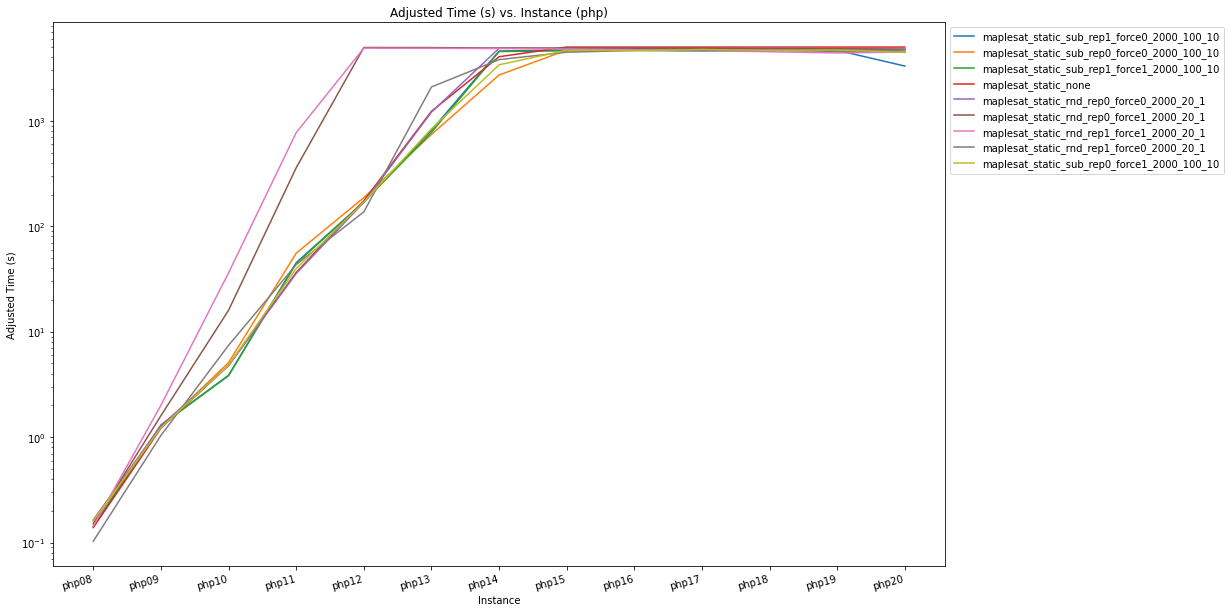

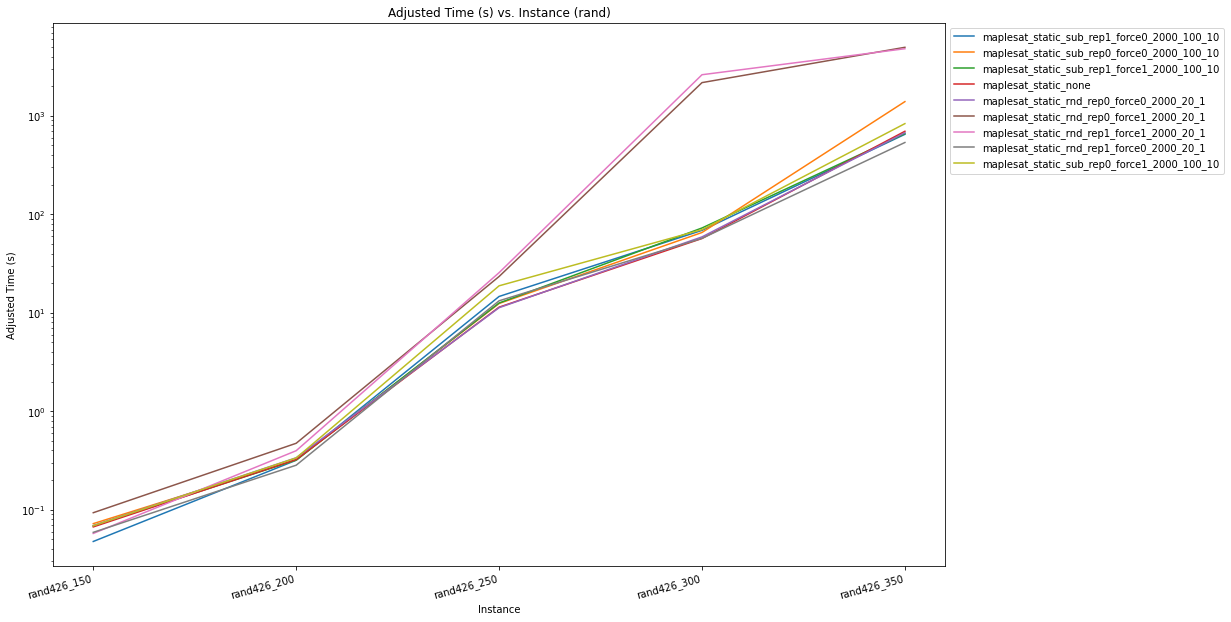

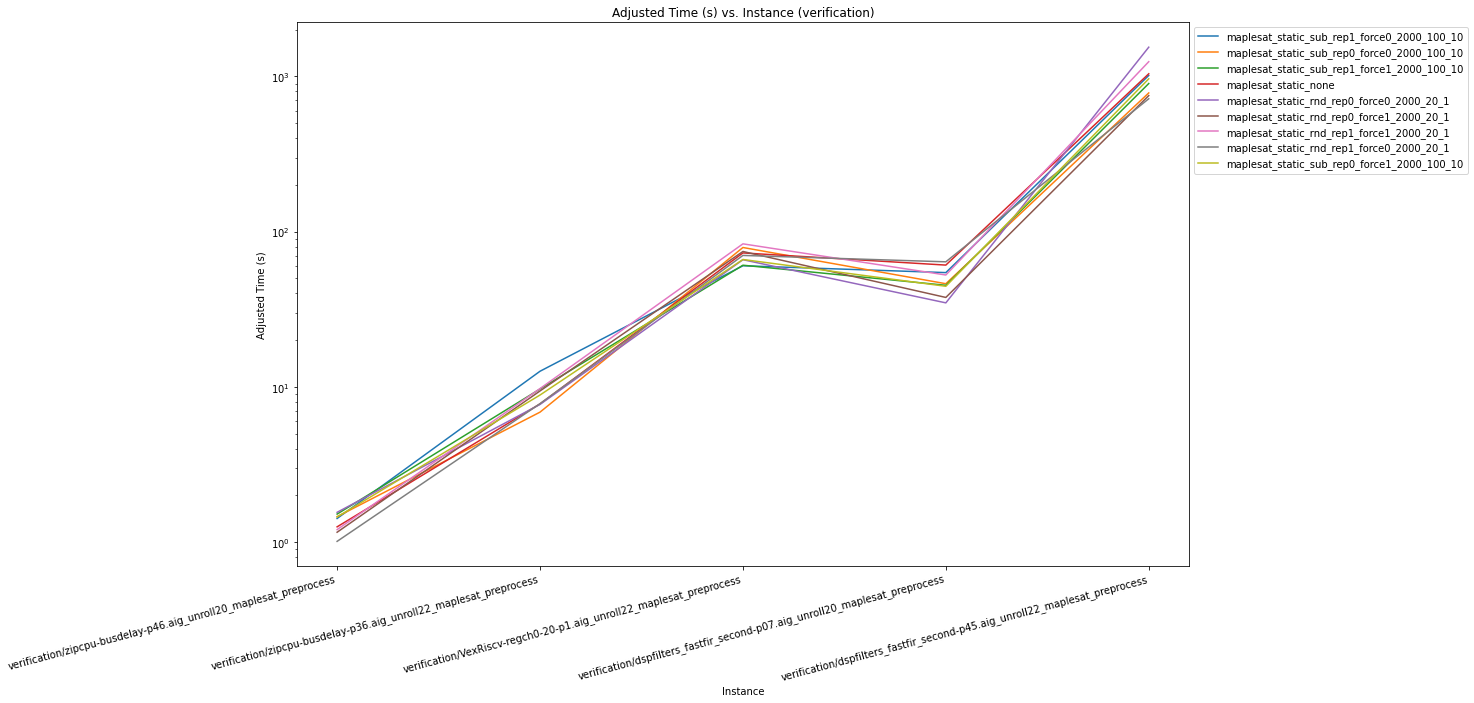

In [8]:
plotPerProblemVariant(solvers, problems_by_variant, 'adjusted_time', 'Adjusted Time (s)')

## Total Time (s) vs. Instance

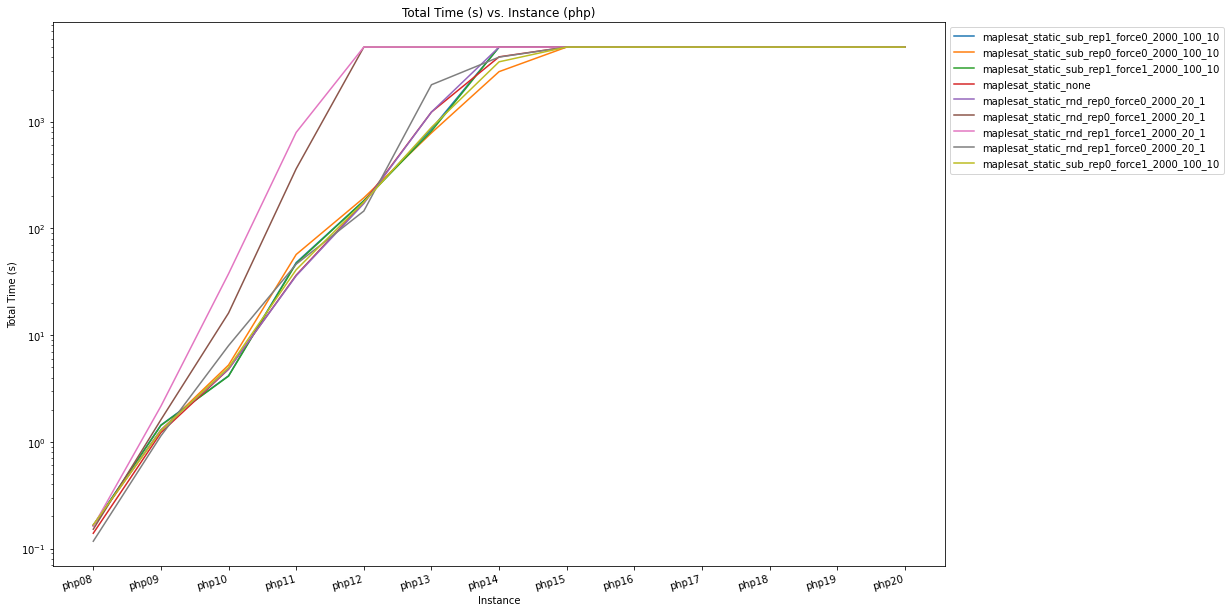

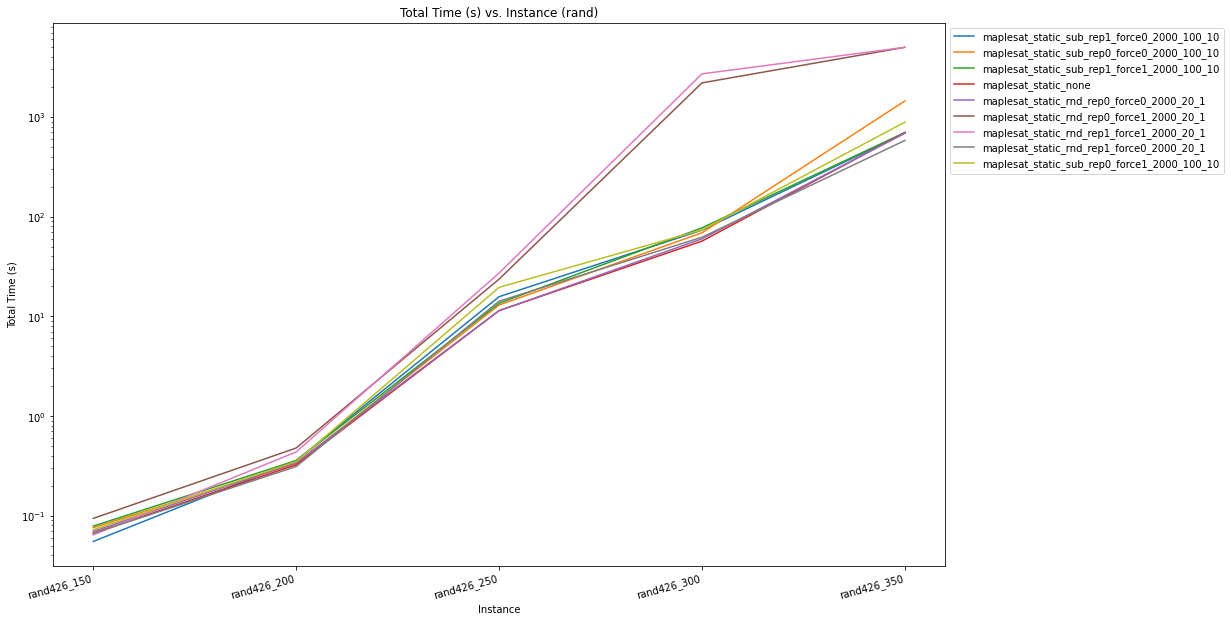

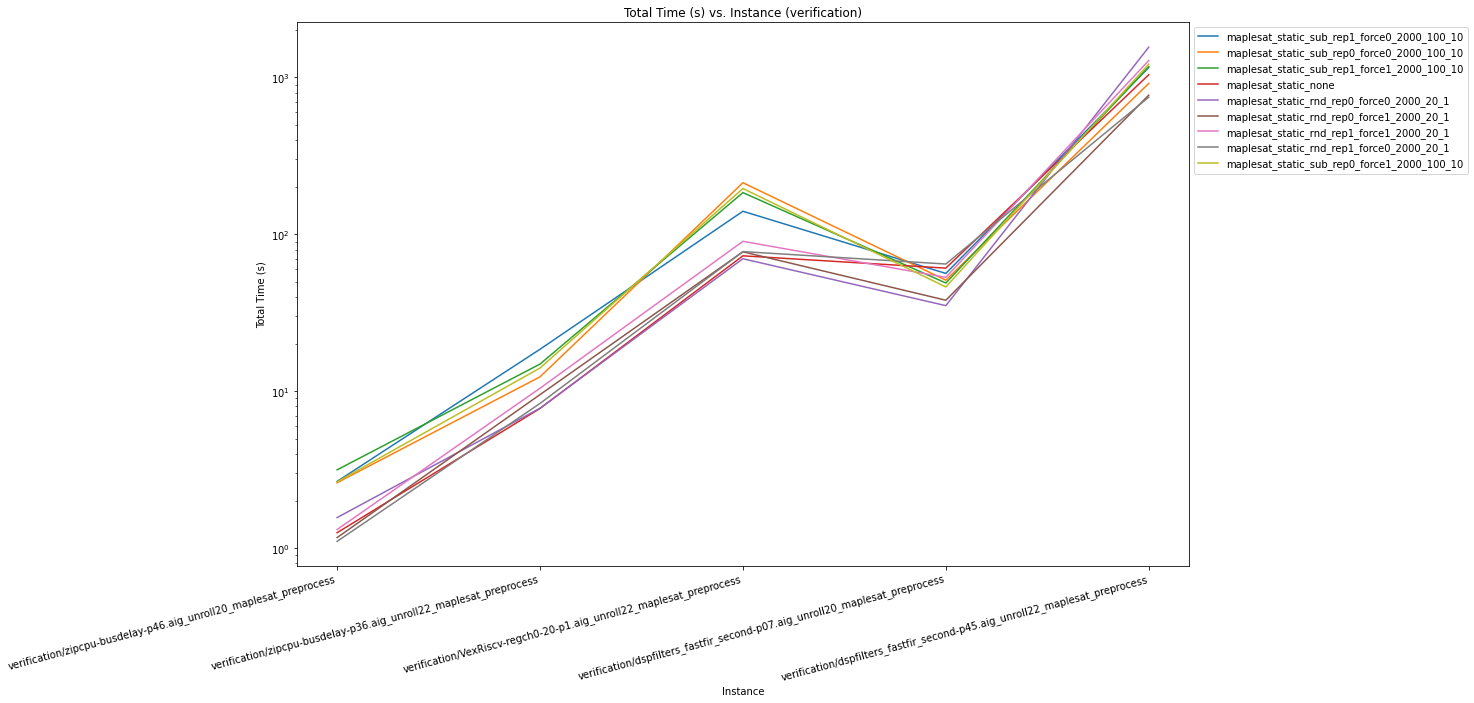

In [9]:
plotPerProblemVariant(solvers, problems_by_variant, 'cpu_time', 'Total Time (s)')

## GLR vs. Instance

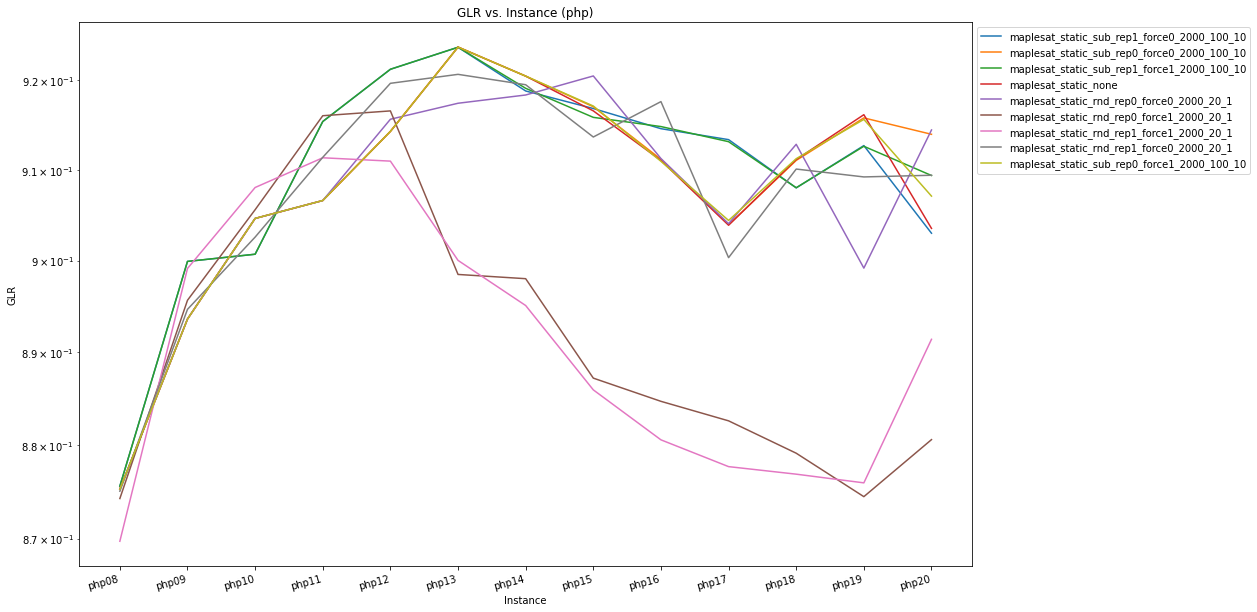

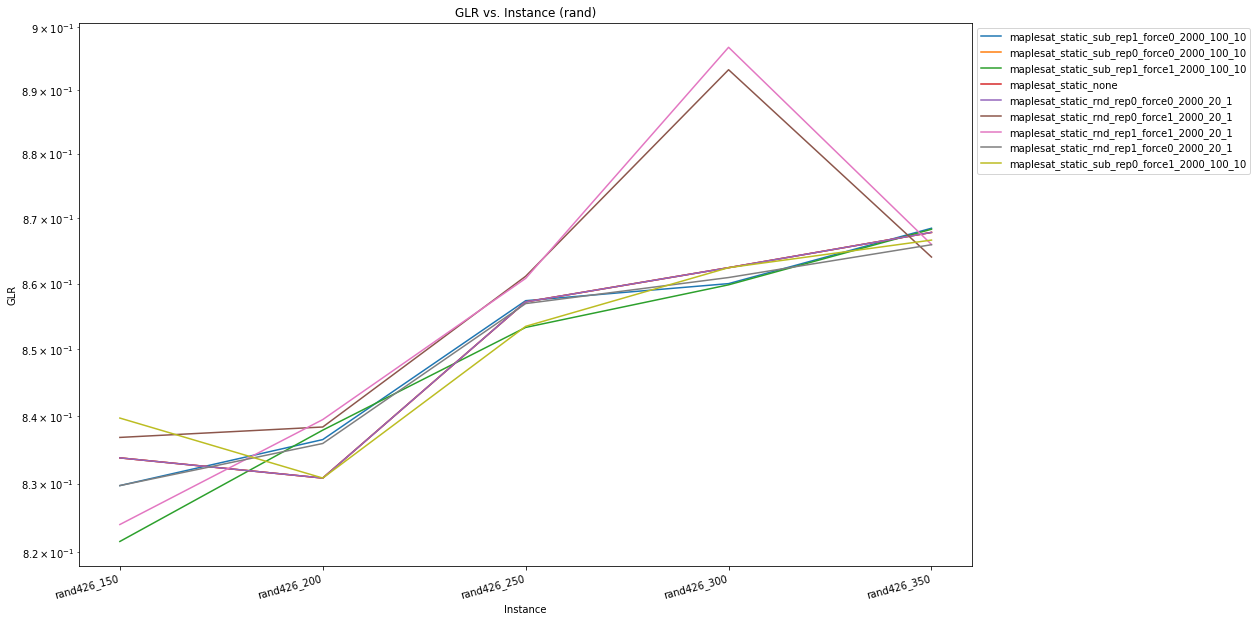

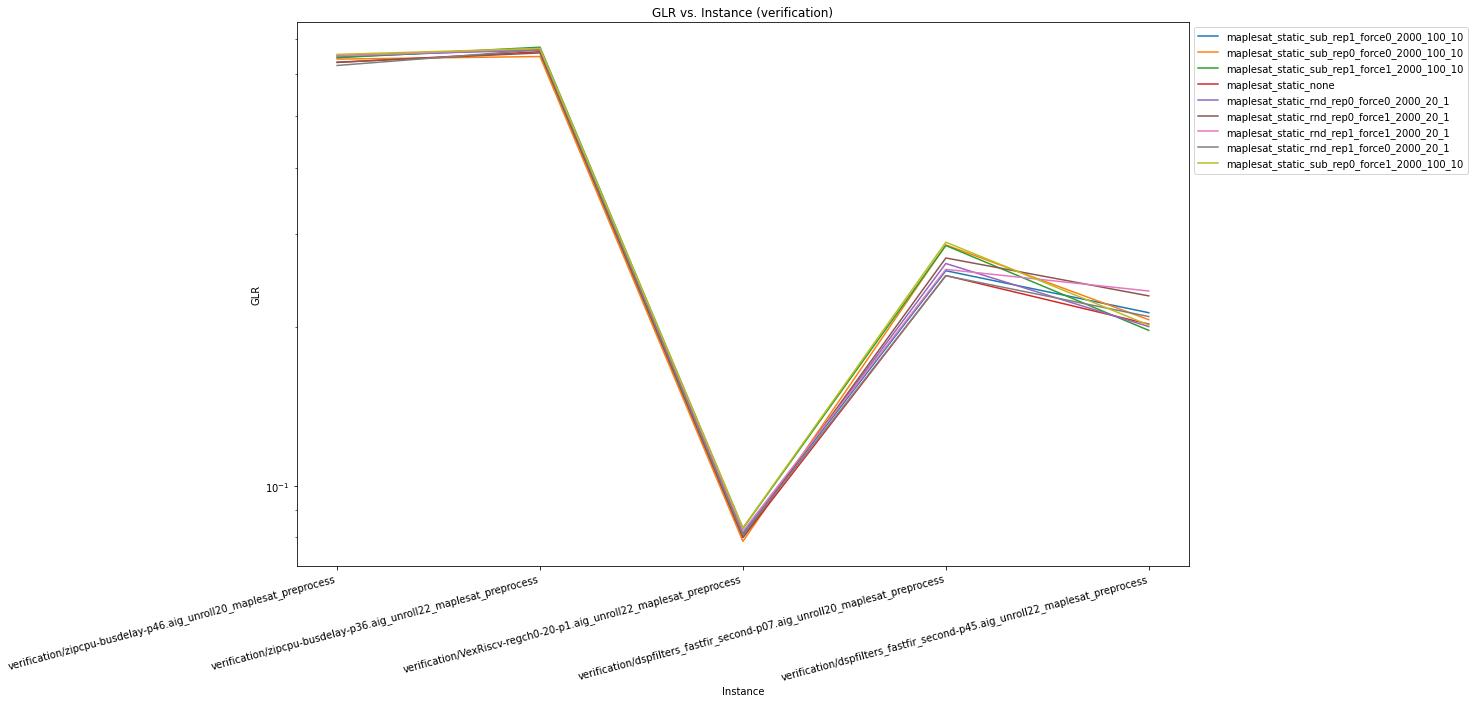

In [10]:
plotPerProblemVariant(solvers, problems_by_variant, 'conf_per_dec', 'GLR')

## Average LBD vs. Instance

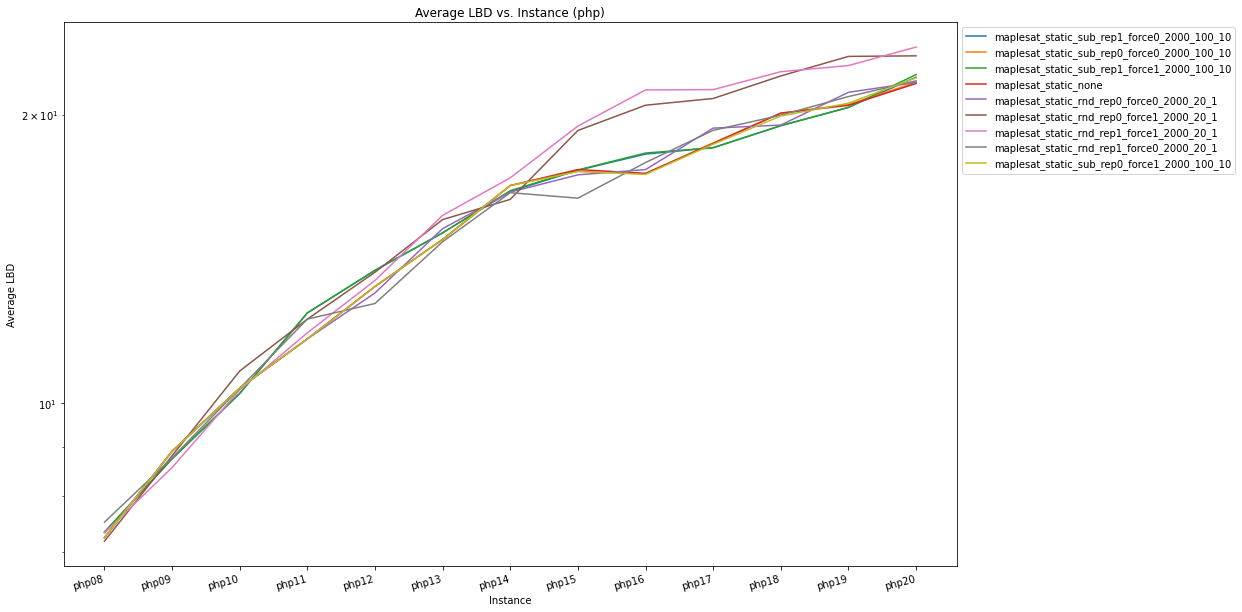

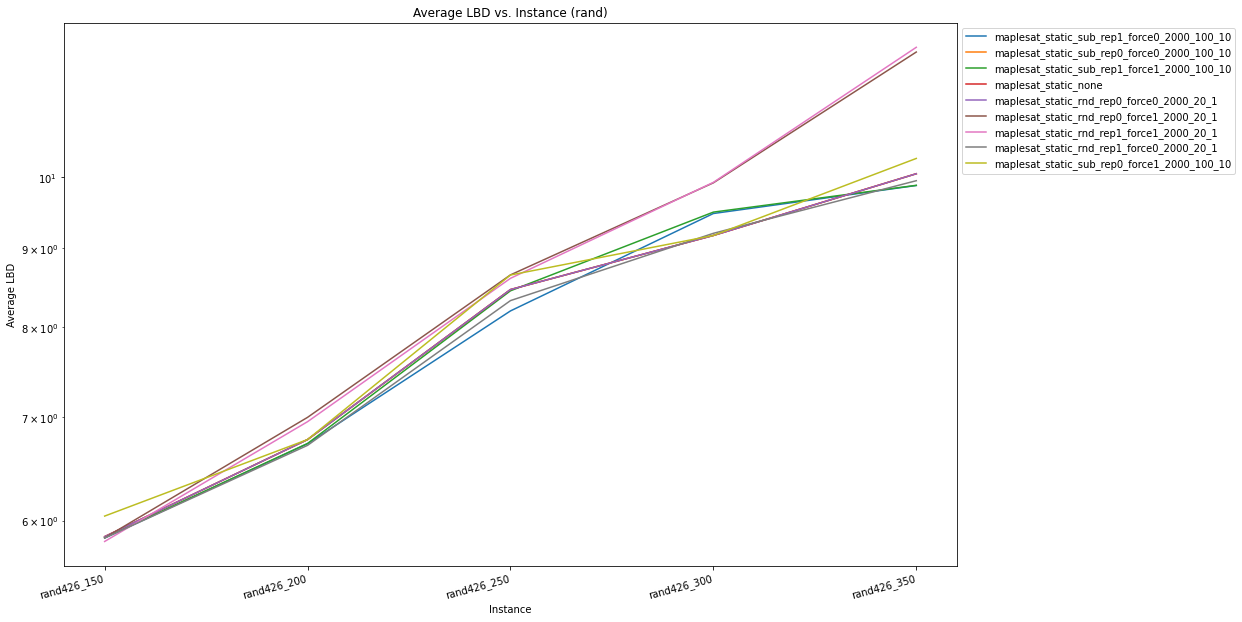

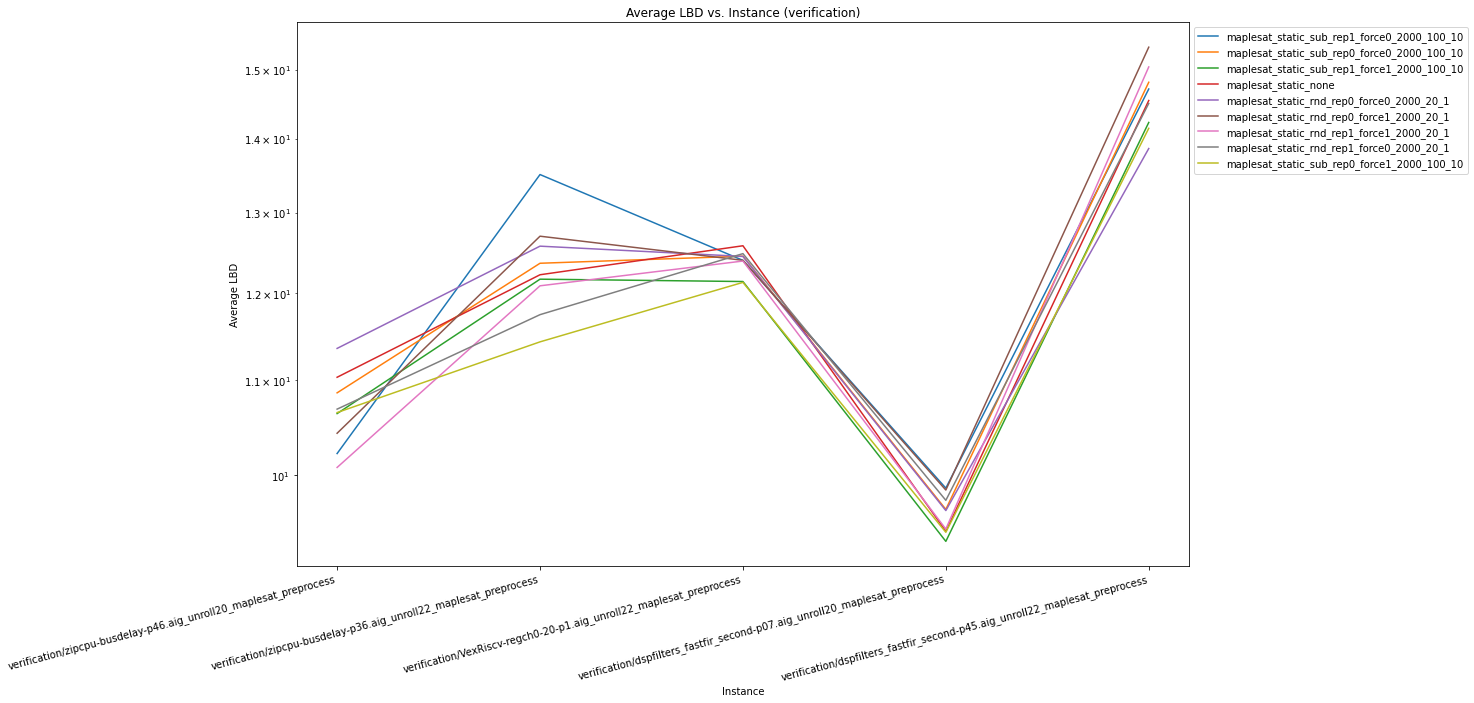

In [11]:
plotPerProblemVariant(solvers, problems_by_variant, 'avg_lbd', 'Average LBD')

## Number of Extension Variables vs. Instance

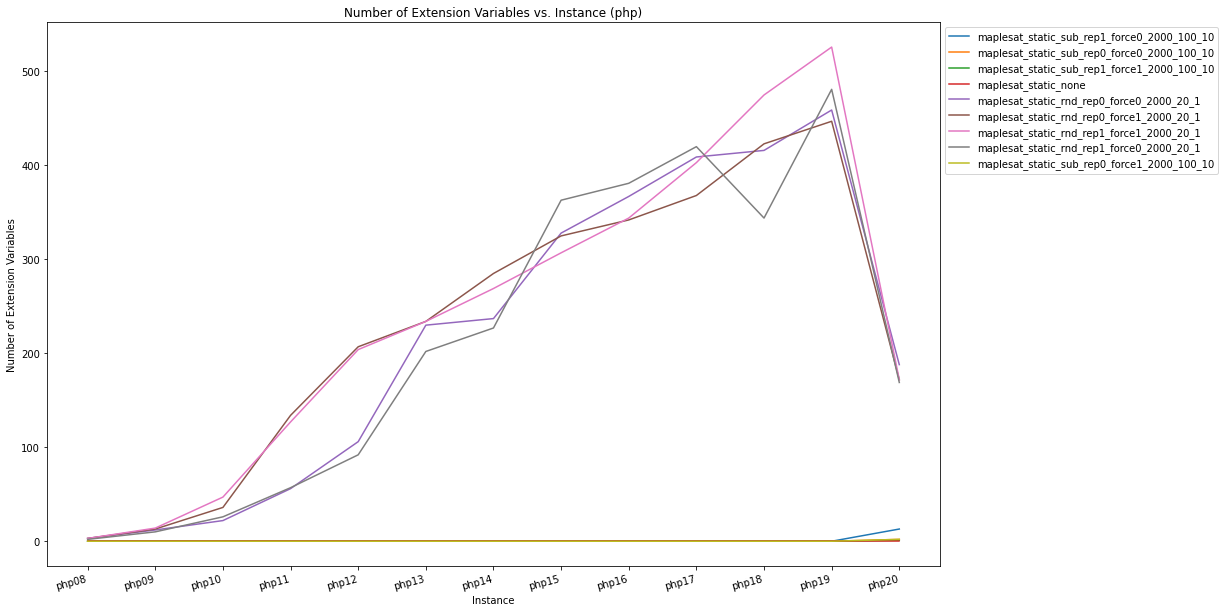

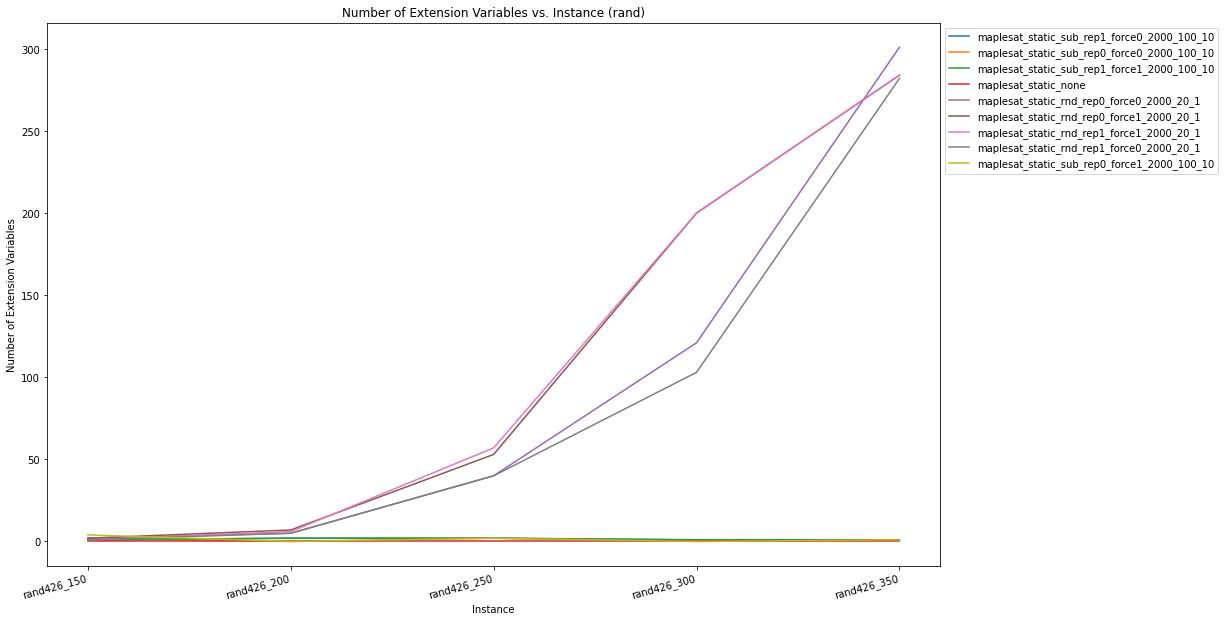

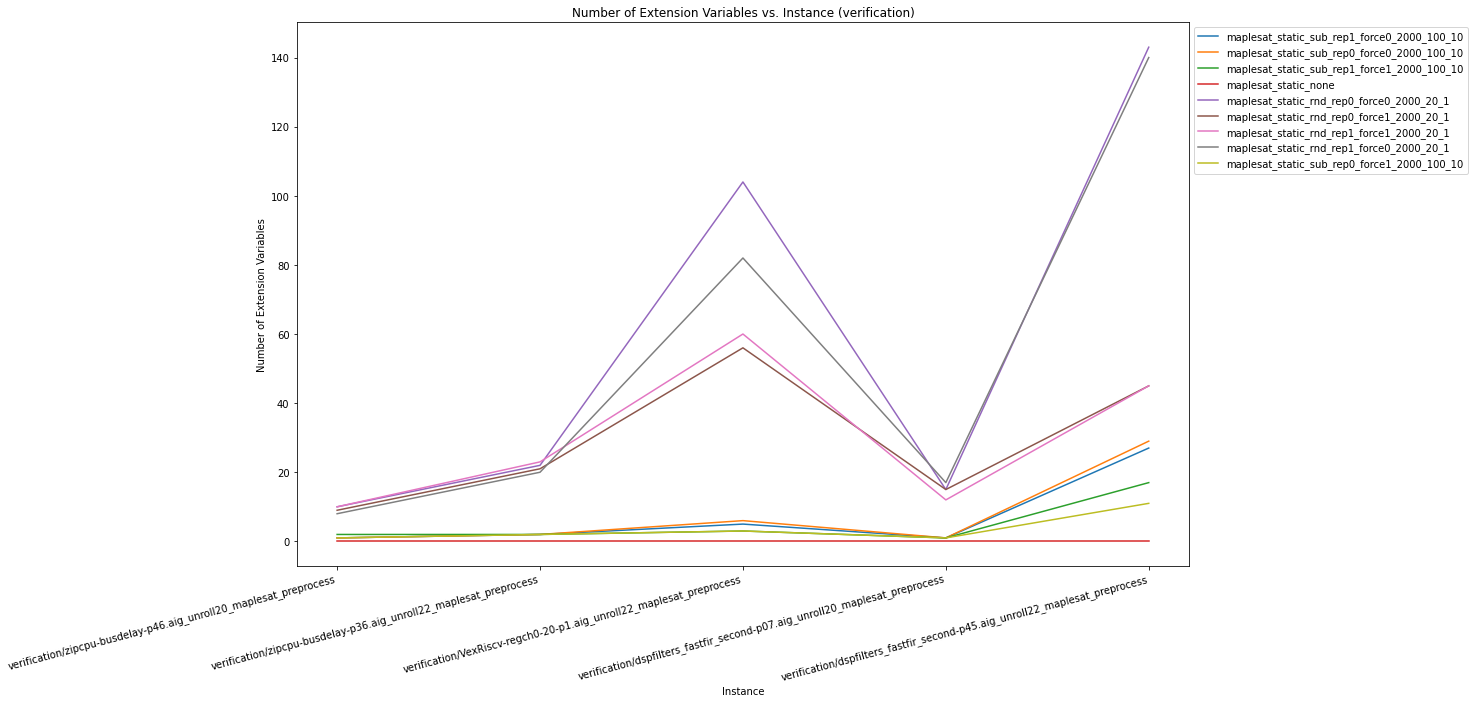

In [12]:
plotPerProblemVariant(solvers, problems_by_variant, 'num_ev', 'Number of Extension Variables', False)

## Extension Clause Conflict Fraction vs. Instance

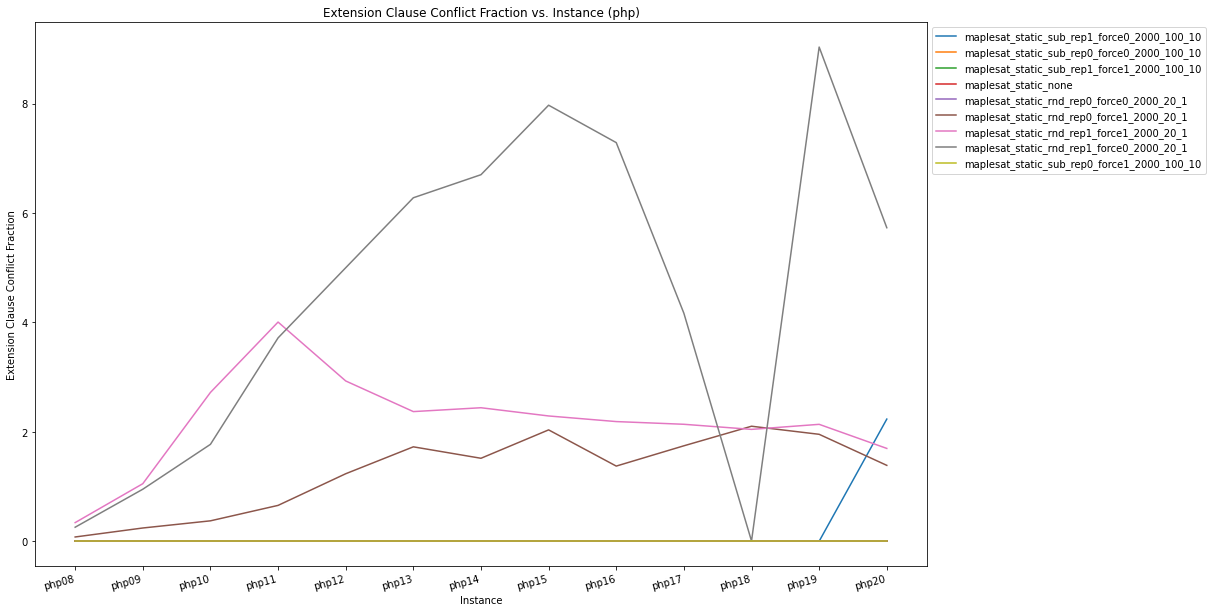

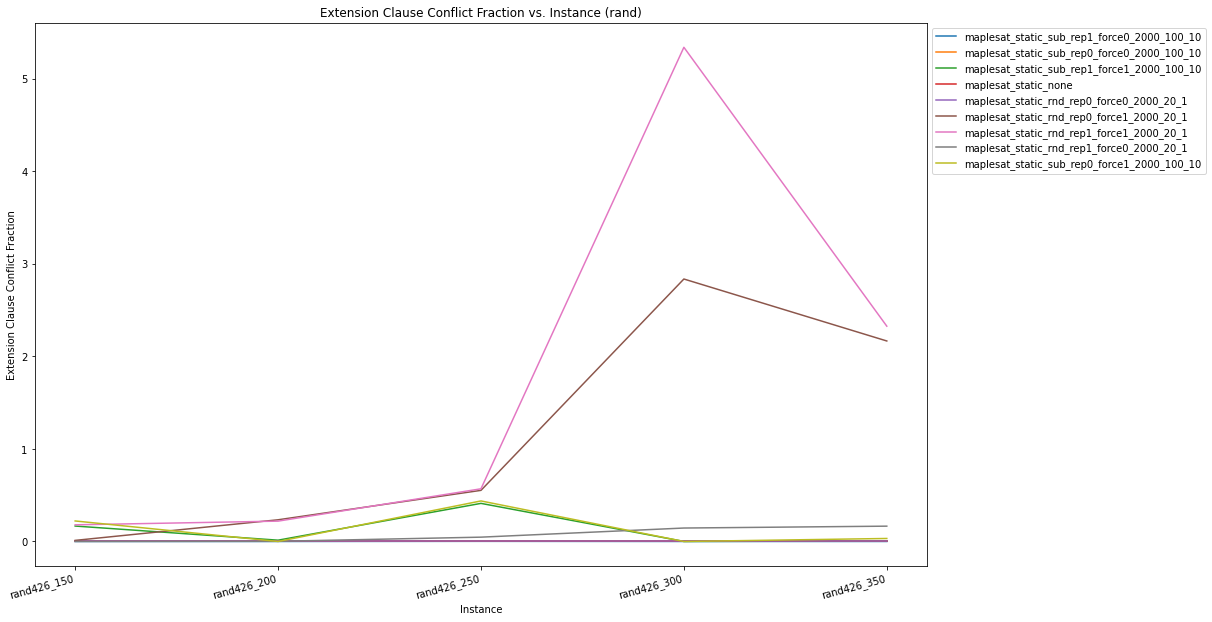

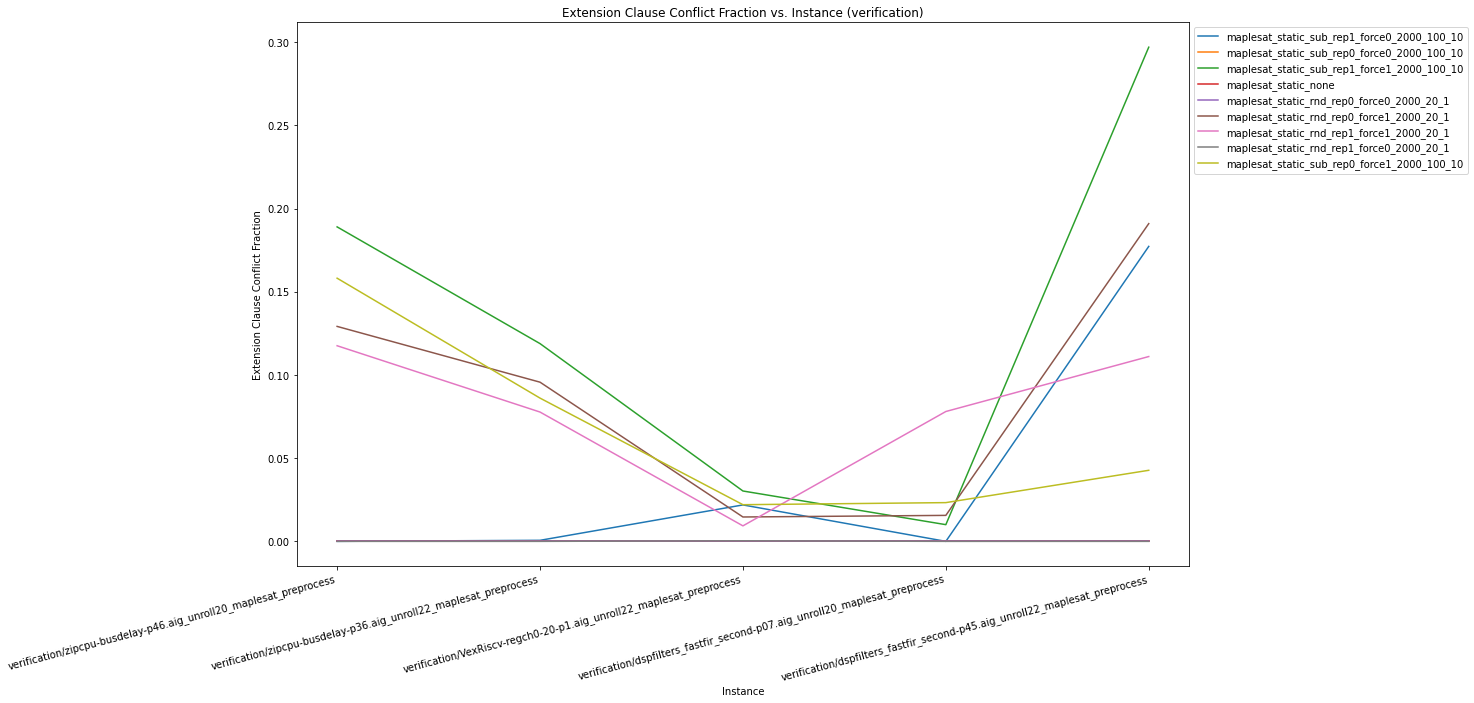

In [13]:
plotPerProblemVariant(solvers, problems_by_variant, 'ev_conf_frac', 'Extension Clause Conflict Fraction', False)